In [52]:
import torch
import torch.optim as optim
import torch.utils.data
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

import numpy as np
from sklearn.model_selection import train_test_split

[[3, 1, 5, 7, 2, 4, 6], [8, 10, 0]]

In [65]:
# Parse file nums to dicts
def parseAnnotationNums(f):
    lines = []
    for line in f.readlines():
        lines.append(line.replace('\n', ''))
    return lines
        
annotation_file_path = os.getcwd() + '/../data/annotations'
annotations_files = os.listdir(annotation_file_path)
annotation_dict_train = {}
annotation_dict_dev = {}
for file in annotations_files:
    f = open(annotation_file_path  + '/' + file, "r")
    annotation = file.split('.')
    train_nums, dev_nums = train_test_split(parseAnnotationNums(f), test_size=0.2)
    annotation_dict_train[annotation[0]] = train_nums
    annotation_dict_dev[annotation[0]] = dev_nums

In [85]:
import shutil

# RUN THIS CELL ONLY ONCE

os.mkdir(os.getcwd() + '/../data_organized')
os.mkdir(os.getcwd() + '/../data_organized/dev')
os.mkdir(os.getcwd() + '/../data_organized/train')


TRAIN_DESTINATION_PATH = os.getcwd() + '/../data_organized/train/'
DEV_DESTINATION_PATH = os.getcwd() + '/../data_organized/dev/'

img_file_path = os.getcwd() + '/../data/images/'

for ann in annotation_dict_train.keys():
    os.mkdir(TRAIN_DESTINATION_PATH + ann)
    for num in annotation_dict_train[ann]:
        img_file_name = 'im' + num + '.jpg'
        shutil.copy(img_file_path + img_file_name, TRAIN_DESTINATION_PATH + ann)

for ann in annotation_dict_dev.keys():
    os.mkdir(DEV_DESTINATION_PATH + ann)
    for num in annotation_dict_dev[ann]:
        img_file_name = 'im' + num + '.jpg'
        shutil.copy(img_file_path + img_file_name, DEV_DESTINATION_PATH + ann)

In [137]:
#--- hyperparameters ---
N_EPOCHS = 10
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_DEV = 16
LR = 0.001

In [119]:
NUM_CLASSES = 14
DATA_DIR = os.getcwd() + '/../data_organized/'

In [118]:
# We transform image files' contents to tensors
# Plus, we can add random transformations to the training data if we like
# Think on what kind of transformations may be meaningful for this data.
# Eg., horizontal-flip is definitely a bad idea for sign language data.
# You can use another transformation here if you find a better one.
train_transform = transforms.Compose([transforms.ColorJitter(),
                                      transforms.RandomPerspective(distortion_scale=0.2),
                                      transforms.ToTensor()])
dev_transform = transforms.Compose([transforms.ToTensor()])

train_set = datasets.ImageFolder(DATA_DIR + 'train', transform=train_transform)
dev_set   = datasets.ImageFolder(DATA_DIR + 'dev',   transform=test_transform)
# test_set  = datasets.ImageFolder(DATA_DIR % 'test',  transform=test_transform)


# Create Pytorch data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dataset=dev_set, batch_size=BATCH_SIZE_DEV, shuffle=True)

In [138]:
#--- model ---
class CNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(32768, NUM_CLASSES)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

using cpu
Training: Epoch 0 - Batch 0/32: Loss: 2.6182 | Dev Acc: 13.281% (17/128)
Training: Epoch 0 - Batch 1/32: Loss: 7.0076 | Dev Acc: 18.750% (48/256)
Training: Epoch 0 - Batch 2/32: Loss: 10.9143 | Dev Acc: 16.146% (62/384)
Training: Epoch 0 - Batch 3/32: Loss: 10.8138 | Dev Acc: 15.234% (78/512)
Training: Epoch 0 - Batch 4/32: Loss: 11.7013 | Dev Acc: 17.656% (113/640)
Training: Epoch 0 - Batch 5/32: Loss: 12.1344 | Dev Acc: 17.318% (133/768)
Training: Epoch 0 - Batch 6/32: Loss: 12.7417 | Dev Acc: 18.304% (164/896)
Training: Epoch 0 - Batch 7/32: Loss: 12.8330 | Dev Acc: 17.578% (180/1024)
Training: Epoch 0 - Batch 8/32: Loss: 13.3842 | Dev Acc: 16.580% (191/1152)
Training: Epoch 0 - Batch 9/32: Loss: 13.3693 | Dev Acc: 15.703% (201/1280)
Training: Epoch 0 - Batch 10/32: Loss: 13.1623 | Dev Acc: 15.696% (221/1408)
Training: Epoch 0 - Batch 11/32: Loss: 12.7337 | Dev Acc: 15.039% (231/1536)
Training: Epoch 0 - Batch 12/32: Loss: 12.1910 | Dev Acc: 15.505% (258/1664)
Training: Ep

Training: Epoch 3 - Batch 10/32: Loss: 2.0564 | Dev Acc: 32.031% (451/1408)
Training: Epoch 3 - Batch 11/32: Loss: 2.0733 | Dev Acc: 30.990% (476/1536)
Training: Epoch 3 - Batch 12/32: Loss: 2.0539 | Dev Acc: 31.430% (523/1664)
Training: Epoch 3 - Batch 13/32: Loss: 2.0621 | Dev Acc: 31.696% (568/1792)
Training: Epoch 3 - Batch 14/32: Loss: 2.0666 | Dev Acc: 31.979% (614/1920)
Training: Epoch 3 - Batch 15/32: Loss: 2.0571 | Dev Acc: 32.178% (659/2048)
Training: Epoch 3 - Batch 16/32: Loss: 2.0570 | Dev Acc: 32.031% (697/2176)
Training: Epoch 3 - Batch 17/32: Loss: 2.0527 | Dev Acc: 32.075% (739/2304)
Training: Epoch 3 - Batch 18/32: Loss: 2.0392 | Dev Acc: 32.401% (788/2432)
Training: Epoch 3 - Batch 19/32: Loss: 2.0446 | Dev Acc: 32.461% (831/2560)
Training: Epoch 3 - Batch 20/32: Loss: 2.0477 | Dev Acc: 32.292% (868/2688)
Training: Epoch 3 - Batch 21/32: Loss: 2.0450 | Dev Acc: 32.173% (906/2816)
Training: Epoch 3 - Batch 22/32: Loss: 2.0488 | Dev Acc: 31.963% (941/2944)
Training: Ep

Training: Epoch 6 - Batch 19/32: Loss: 1.7128 | Dev Acc: 38.164% (977/2560)
Training: Epoch 6 - Batch 20/32: Loss: 1.7185 | Dev Acc: 37.946% (1020/2688)
Training: Epoch 6 - Batch 21/32: Loss: 1.7285 | Dev Acc: 37.749% (1063/2816)
Training: Epoch 6 - Batch 22/32: Loss: 1.7316 | Dev Acc: 37.670% (1109/2944)
Training: Epoch 6 - Batch 23/32: Loss: 1.7339 | Dev Acc: 37.793% (1161/3072)
Training: Epoch 6 - Batch 24/32: Loss: 1.7400 | Dev Acc: 37.594% (1203/3200)
Training: Epoch 6 - Batch 25/32: Loss: 1.7556 | Dev Acc: 37.560% (1250/3328)
Training: Epoch 6 - Batch 26/32: Loss: 1.7590 | Dev Acc: 37.529% (1297/3456)
Training: Epoch 6 - Batch 27/32: Loss: 1.7680 | Dev Acc: 37.305% (1337/3584)
Training: Epoch 6 - Batch 28/32: Loss: 1.7688 | Dev Acc: 37.258% (1383/3712)
Training: Epoch 6 - Batch 29/32: Loss: 1.7773 | Dev Acc: 36.927% (1418/3840)
Training: Epoch 6 - Batch 30/32: Loss: 1.7811 | Dev Acc: 36.920% (1465/3968)
Training: Epoch 6 - Batch 31/32: Loss: 1.7869 | Dev Acc: 36.824% (1491/4049)


Training: Epoch 9 - Batch 28/32: Loss: 1.2829 | Dev Acc: 51.751% (1921/3712)
Training: Epoch 9 - Batch 29/32: Loss: 1.2878 | Dev Acc: 51.615% (1982/3840)
Training: Epoch 9 - Batch 30/32: Loss: 1.2858 | Dev Acc: 51.689% (2051/3968)
Training: Epoch 9 - Batch 31/32: Loss: 1.2847 | Dev Acc: 51.741% (2095/4049)
Epoch train loss: 41.11091351509094
Previous epoch train loss: 49.61323440074921


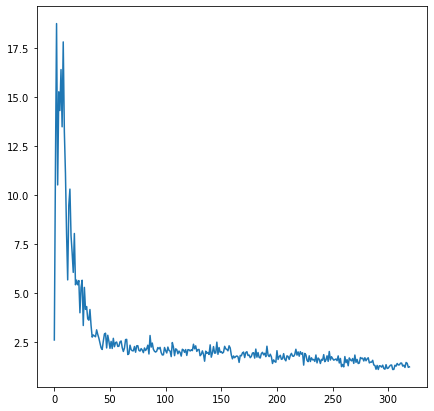

In [148]:
#--- set up ---
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('using gpu')
else:
    print('using cpu')
    device = torch.device('cpu')

model = CNN().to(device)

# OPTIMIZERS & REGURALIZATION

# EARLY STOP AFTER 8th EPOCH, when train acc about 98.6%, AVG Test acc 96.15%
optimizer_1 = optim.Adam(model.parameters(), lr=LR, weight_decay=0.05)

# EARLY STOP AFTER 3rd EPOCH, when train acc about 92.86%, AVG Test acc 82.77%
optimizer_2 = optim.RMSprop(model.parameters(), lr=LR, weight_decay=0.1)

# RUNS THROUGH ALL 10 EPOCHS, final train acc about 95.36%, AVG Test acc 91.26%
optimizer_3 = optim.SGD(model.parameters(), lr=LR, momentum=0.5)

loss_function = nn.CrossEntropyLoss()

optimizer = optimizer_1

#--- TRAINING WITH DEV SET ---

previous_dev_loss = 1000000

batch_losses = []

for epoch in range(N_EPOCHS):
    dev_loss = 0
    dev_correct = 0
    total = 0
    for batch_num, (data, target) in enumerate(dev_loader):
        data, target = data.to(device), target.to(device)
                
        # Compute prediction error
        optimizer.zero_grad()
        pred = model(data)
        loss = loss_function(pred, target)

        dev_loss += loss.item()
        
        batch_losses.append(loss.item())
        
        total += len(target)
        dev_correct += torch.sum(pred.argmax(1) == target)
        
        # Backpropagation
        loss.backward()
        optimizer.step()

        print('Training: Epoch %d - Batch %d/%d: Loss: %.4f | Dev Acc: %.3f%% (%d/%d)' % 
              (epoch, batch_num, len(dev_loader), dev_loss / (batch_num + 1), 
               100. * dev_correct / total, dev_correct, total))
    
    print("Epoch train loss: " + str(dev_loss))
    print("Previous epoch train loss: " + str(previous_dev_loss))
    
    # EARLY STOPPING
    if dev_loss > previous_dev_loss:
        print('early stopping')
        break
        
    previous_dev_loss = dev_loss

plt.figure(figsize=(7, 7))
plt.plot(batch_losses)
plt.show()

In [143]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

#--- train ---
train_loss = 0
train_correct = 0
total = 0

train_acc_all = 0

preds = []
targets = []

with torch.no_grad():
    for batch_num, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        pred = model(data)
        loss = loss_function(pred, target)
        
        test_loss += loss.item()
        total += len(target)
        train_correct += torch.sum(pred.argmax(1) == target)
        preds.extend(pred.argmax(1).cpu().numpy())
        targets.extend(target.cpu().numpy())
        
        test_acc_all += (test_correct / total)

        print('Evaluating: Batch %d/%d: Loss: %.4f | Test Acc: %.3f%% (%d/%d)' % 
              (batch_num, len(train_loader), train_loss / (batch_num + 1), 
               100. * train_correct / total, train_correct, total))

    cf_matrix = confusion_matrix(targets, preds)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix) * 1000, 
                         index = [i for i in annotation_dict_train.keys()],
                         columns=[i for i in annotation_dict_train.keys()])
    plt.figure(figsize=(12, 7))
    sn.heatmap(df_cm, annot=True)

    
print('AVG test acc:' + str(test_acc_all*100/len(test_loader)) + '%')

Evaluating: Batch 0/127: Loss: 0.0000 | Test Acc: 30.469% (39/128)
Evaluating: Batch 1/127: Loss: 0.0000 | Test Acc: 27.734% (71/256)
Evaluating: Batch 2/127: Loss: 0.0000 | Test Acc: 28.646% (110/384)
Evaluating: Batch 3/127: Loss: 0.0000 | Test Acc: 26.953% (138/512)
Evaluating: Batch 4/127: Loss: 0.0000 | Test Acc: 26.250% (168/640)
Evaluating: Batch 5/127: Loss: 0.0000 | Test Acc: 26.693% (205/768)
Evaluating: Batch 6/127: Loss: 0.0000 | Test Acc: 27.567% (247/896)
Evaluating: Batch 7/127: Loss: 0.0000 | Test Acc: 27.637% (283/1024)
Evaluating: Batch 8/127: Loss: 0.0000 | Test Acc: 26.823% (309/1152)
Evaluating: Batch 9/127: Loss: 0.0000 | Test Acc: 27.422% (351/1280)
Evaluating: Batch 10/127: Loss: 0.0000 | Test Acc: 27.557% (388/1408)
Evaluating: Batch 11/127: Loss: 0.0000 | Test Acc: 27.474% (422/1536)
Evaluating: Batch 12/127: Loss: 0.0000 | Test Acc: 27.704% (461/1664)
Evaluating: Batch 13/127: Loss: 0.0000 | Test Acc: 27.679% (496/1792)
Evaluating: Batch 14/127: Loss: 0.0000 

KeyboardInterrupt: 